In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from tqdm import tqdm
from IPython.display import Image
import seaborn as sns
import calmap
from datetime import datetime, timedelta
import math
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import make_scorer

In [111]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\79636\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'product', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# M5 Forecasting - Accuracy
Vladislav Molodtsov, Irina Shushpannikova

https://www.kaggle.com/c/m5-forecasting-accuracy/data

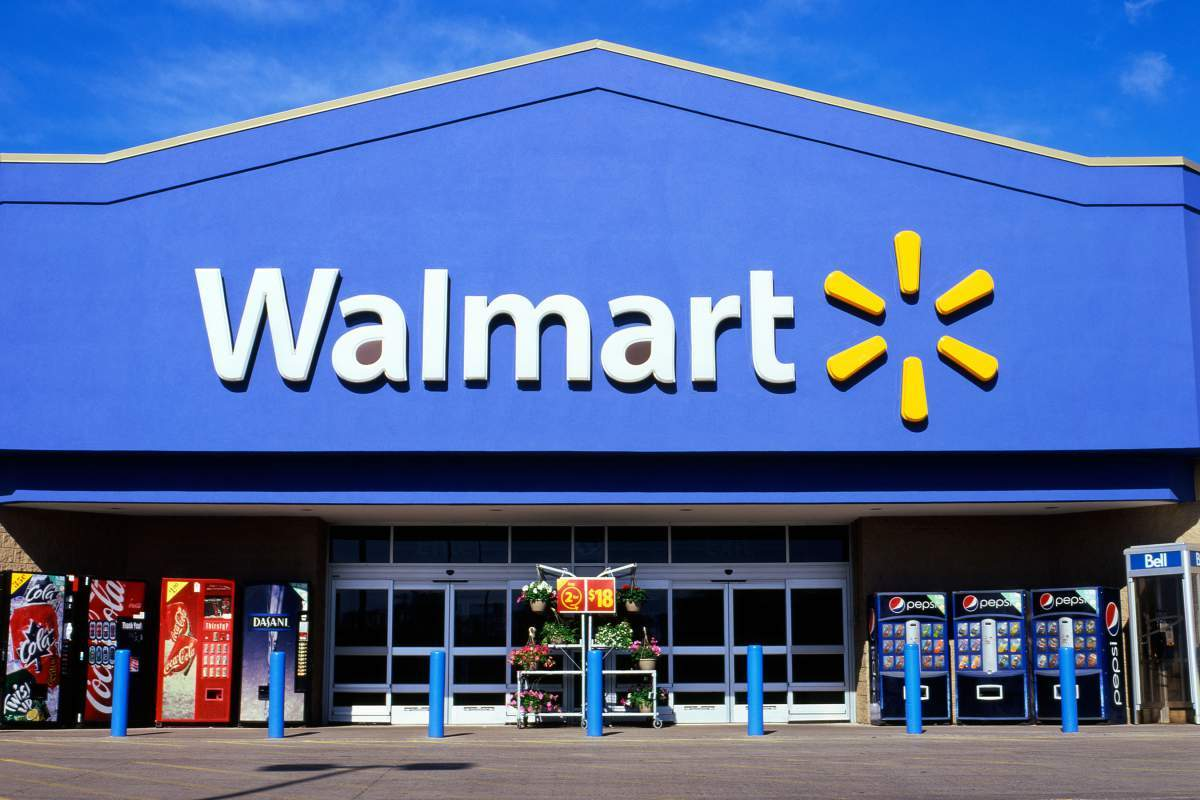

In [112]:
Image(filename='pics/view.jpg')

# Data exploration

### Available data:
* *sales_train_validation.csv* - daily sales
* *calendar.csv* - dates, holidays, discounts
* *sell_prices.csv* - commodity prices

In [113]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')

In [114]:
sales_train_validation.iloc[:12,:12]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,0,4
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,0,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0


In [115]:
calendar = pd.read_csv('calendar.csv')
date=calendar.loc[:,['d','date']]
date.set_index('d', inplace=True)
date=date.reset_index(drop=True)
calendar.drop(index=np.arange(len(calendar)-1,len(calendar)-57, -1), inplace=True)

In [116]:
calendar.iloc[2:10,:]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [117]:
def plot_data(product, name="Product 1"):
    data=sales_train_validation[sales_train_validation.id == product].iloc[0]
    data=pd.DataFrame(data)
    data=data.drop(axis=0, labels=['id','item_id','dept_id','cat_id','store_id','state_id'])

    fig, ax = plt.subplots(figsize=(12,6))
    data.plot(title=name, fontsize=15, legend=False, ax=ax)

    ax.set_ylabel('Sales', size=25)
    ax.title.set_size(30)

    plt.show()

In [118]:
products_to_analyze = [
    'FOODS_1_006_CA_1_validation',
    'FOODS_1_016_CA_1_validation',
    'FOODS_1_018_CA_1_validation',
    'FOODS_1_024_CA_1_validation',
    'FOODS_1_054_CA_1_validation'
]

In [119]:
data = list()
for i, product in enumerate(products_to_analyze):
    df = pd.DataFrame(sales_train_validation[sales_train_validation.id == product].iloc[0])
    df = df.drop(axis=0, labels=['id','item_id','dept_id','cat_id','store_id','state_id'])
    df = df.reset_index(drop=True)
    df.columns = ["sales"]
    df.sales = df.sales.astype('int')

    df=pd.concat([df,date],axis=1)
    df.dropna(inplace=True)
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    data.append(df)

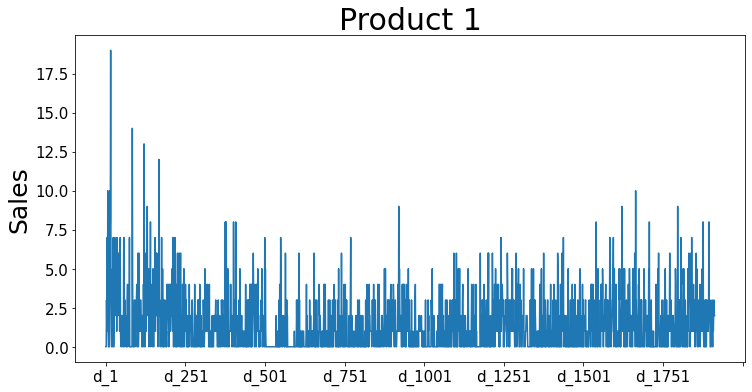

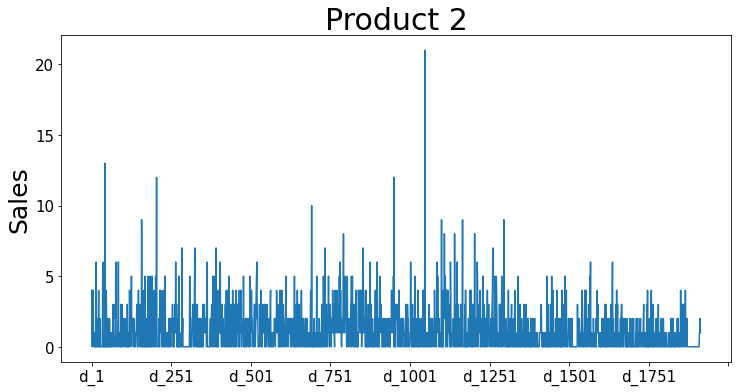

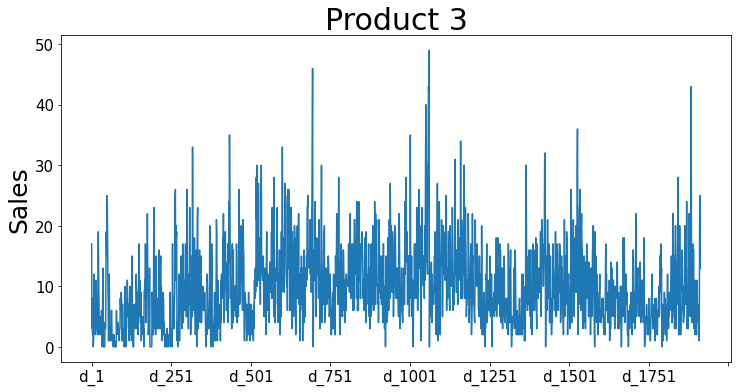

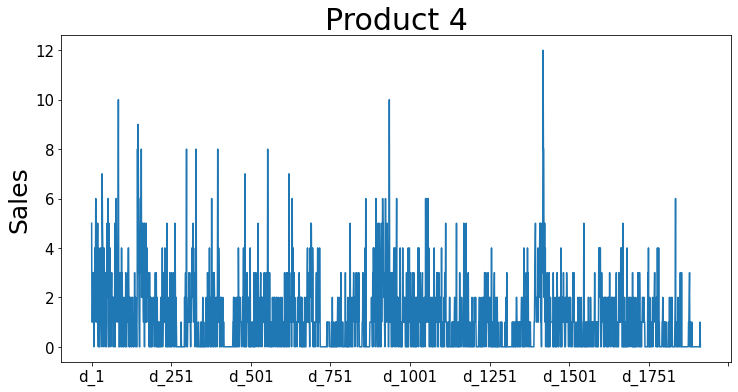

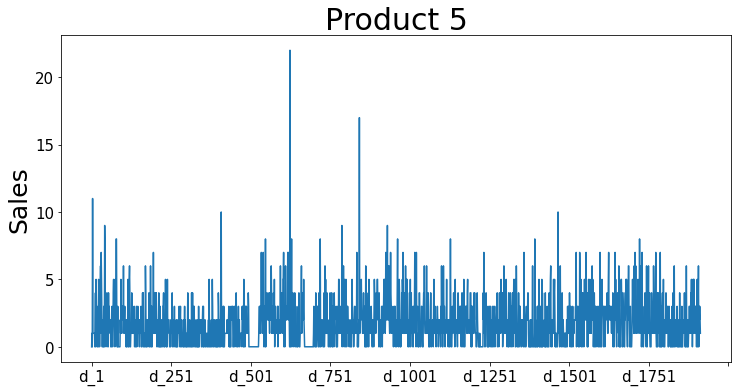

In [120]:
for i, product in enumerate(products_to_analyze):
    plot_data(product, "Product "+str(i+1))

In [121]:
#plotData(products_to_analyze[0])

In [122]:
def calendar_sales(number):
    year=2015
    n_graphs = min(number,len(data))
    fig, axes = plt.subplots(nrows=n_graphs, figsize=(16,12))
    
    for i in range(n_graphs):
        calmap.yearplot(data[i].sales, year=year, ax=axes[i])
        axes[i].yaxis.set_tick_params(labelsize=15)
        axes[i].xaxis.set_tick_params(labelsize=15)
        axes[i].set_title('Sales of Product '+str(i), fontdict={'fontsize':30})

    plt.tight_layout()
    plt.show()

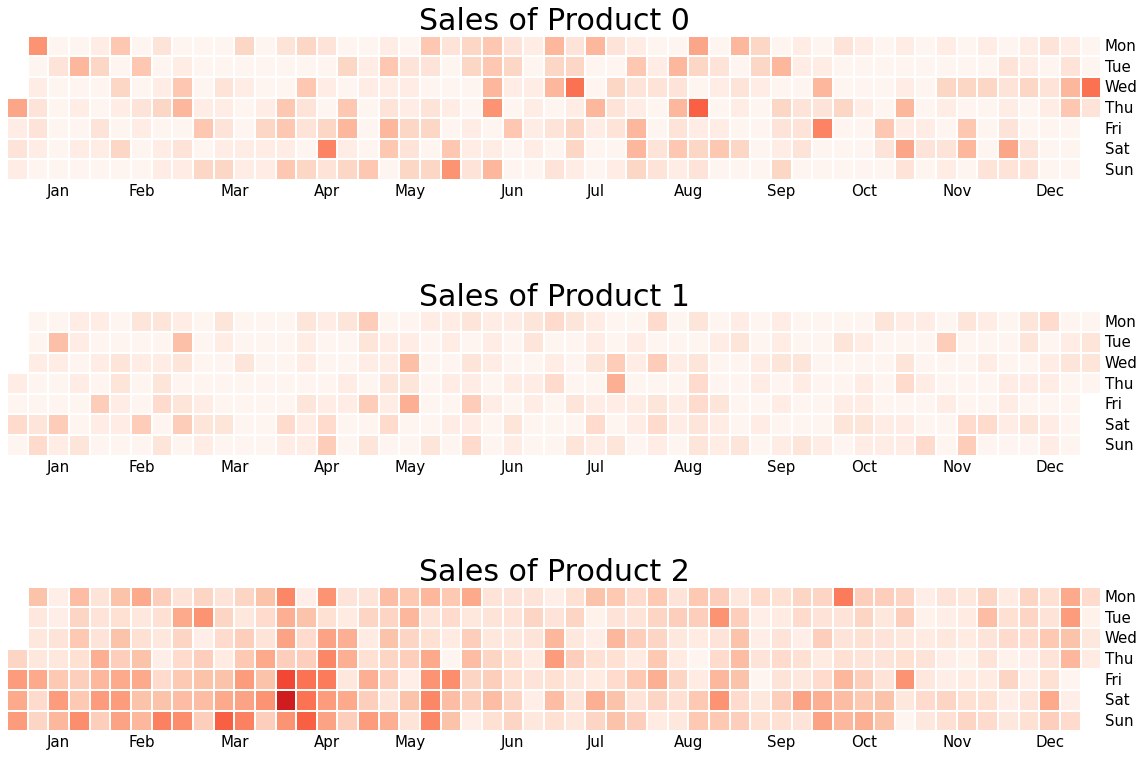

In [123]:
calendar_sales(3)

# Problem formulation

### Prediction of the next 28 days of sales - *Time Series Forecasting*

In [124]:
def add_lags(dataframe, lags):
    columns = list()
    
    for lag in lags:
        shifted = dataframe.shift(lag)
        shifted.columns = ['lag_'+str(lag)]
        columns.append(shifted)
        
    return pd.concat([dataframe, *columns], axis=1).dropna()

In [125]:
lags = [1,2,3,4,5,6,7]

for i in range(len(data)):
    data[i] = add_lags(data[i], lags)

In [126]:
data[0].head()

,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2011-02-05,1.0,10.0,2.0,7.0,1.0,3.0,0.0,0.0
2011-02-06,0.0,1.0,10.0,2.0,7.0,1.0,3.0,0.0
2011-02-07,0.0,0.0,1.0,10.0,2.0,7.0,1.0,3.0
2011-02-08,0.0,0.0,0.0,1.0,10.0,2.0,7.0,1.0
2011-02-09,0.0,0.0,0.0,0.0,1.0,10.0,2.0,7.0


In [127]:
from sklearn.model_selection import train_test_split

In [131]:
# TODO: data - list of dataframes. please make train and test lists as well

def list_train_test_split(data):
    i = 0
    train_list=[]
    test_list=[]
    
    for i, _ in enumerate(data):
        train, test = train_test_split(data[i], shuffle=False, test_size=1.45/100)
        train_list.append(train)
        test_list.append(test)
    return train_list, test_list


In [132]:
data[0]

,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2011-02-05,1.0,10.0,2.0,7.0,1.0,3.0,0.0,0.0
2011-02-06,0.0,1.0,10.0,2.0,7.0,1.0,3.0,0.0
2011-02-07,0.0,0.0,1.0,10.0,2.0,7.0,1.0,3.0
2011-02-08,0.0,0.0,0.0,1.0,10.0,2.0,7.0,1.0
2011-02-09,0.0,0.0,0.0,0.0,1.0,10.0,2.0,7.0
...,...,...,...,...,...,...,...,...
2016-04-20,1.0,2.0,0.0,1.0,3.0,1.0,2.0,0.0
2016-04-21,2.0,1.0,2.0,0.0,1.0,3.0,1.0,2.0
2016-04-22,3.0,2.0,1.0,2.0,0.0,1.0,3.0,1.0


In [133]:
# TODO: please make it lists as well

def features_target_lists(train_list, test_list):
    i = 0
    features_train_list=[]
    target_train_list=[]
    features_test_list=[]
    target_test_list=[]
    
    for i, _ in enumerate(train_list):
        features_train = train_list[i].drop('sales', axis=1)
        target_train = train_list[i]['sales']
        features_test = test_list[i].drop('sales', axis=1)
        target_test = test_list[i]['sales']
        
        features_train_list.append(features_train)
        target_train_list.append(target_train)
        features_test_list.append(features_test)
        target_test_list.append(target_test)
        
    return features_train_list, target_train_list, features_test_list, target_test_list

In [134]:
train_list, test_list = list_train_test_split(data)

print("Train:\tfrom", train_list[0].index.min().date(), "to", train_list[0].index.max().date())
print("Test:\tfrom", test_list[0].index.min().date(), "to", test_list[0].index.max().date())

Train:	from 2011-02-05 to 2016-03-27
Test:	from 2016-03-28 to 2016-04-24


In [135]:
test_list[0].shape

(28, 8)

In [136]:
features_train_list, target_train_list, features_test_list, target_test_list = features_target_lists(train_list, test_list)

In [137]:
features_test_list[1]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,
2016-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Metrics

SMAPE - Symmetric Mean Absolute Percentage Error
$
\frac{1}{n}\sum\limits_{i=1}^n\frac{|y_i-\tilde{y_i}|}{(|y_i|+|\tilde{y_i}|)/2}\times100\%
$

In [138]:
def fittingShow(model, title, data_index):
    
    features_train = features_train_list[data_index]
    target_train = target_train_list[data_index]
    
    pred = model.predict(features_train)
    pred = pd.DataFrame(pred).set_index(target_train.index)[0]

    fig, axes = plt.subplots(figsize=(12,7))

    axes.set_title(title, fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    ind = np.arange(100,400)
    target_train[ind].plot(ax=axes)
    pred[ind].plot(ax=axes,color='r', alpha=0.7)

    axes.set_ylabel('Sales', fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed', 'Fitted'], fontsize=20, loc='upper right')

    plt.tight_layout()
    plt.show()
    
    print('SMAPE: %.5f%%' % smape(target_train, pred))

In [144]:
def choose_best_parameters(model, param_search, data_index):
    
    features_train = features_train_list[data_index]
    target_train = target_train_list[data_index]
    
    cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=8).split(features_train)] 

    gsearch = GridSearchCV(estimator=model, cv=cv,
                           param_grid=param_search, scoring=custom_scorer, n_jobs=-1, 
                           refit=True, return_train_score=True)

    gsearch.fit(features_train, target_train)

    return gsearch

In [150]:
def fit_optimal_model(model, param_search, number, data_index):
    
    features_train = features_train_list[data_index]
    target_train = target_train_list[data_index]
    
    best =  choose_best_parameters(model, param_search, data_index)
    print("Product",str(number))
    print("Optimal model:", best.best_estimator_)
    print("SMAPE on train: ", str(round(smape(target_train, best.predict(features_train)),3))+"%")

    return best.best_estimator_

In [146]:
# param_search = {'n_estimators' : range(100, 400, 20)}
param_search = {'n_estimators' : range(100, 120, 20)}

In [147]:
# TODO: please make it lists as well
best_RFR = fit_optimal_model(RandomForestRegressor(), param_search, 1, 0)

Product 1
Optimal model: RandomForestRegressor()
SMAPE on train:  94.953%


In [149]:
for i in range(len(data)):
    best_RFR = fit_optimal_model(RandomForestRegressor(), param_search, 1, i)
    print('_________________________________')
        
        
        
    

Product 1
Optimal model: RandomForestRegressor()
SMAPE on train:  95.099%
_________________________________
Product 1
Optimal model: RandomForestRegressor()
SMAPE on train:  95.564%
_________________________________
Product 1
Optimal model: RandomForestRegressor()
SMAPE on train:  25.587%
_________________________________
Product 1
Optimal model: RandomForestRegressor()
SMAPE on train:  95.86%
_________________________________
Product 1
Optimal model: RandomForestRegressor()
SMAPE on train:  69.8%
_________________________________


In [ ]:
# Select only one model to fit, e.g. best_RFR[0]
fittingShow(best_RFR,"Product 1 sales fitting", #data_index)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:


best_RFR = fit_optimal_model(LinearRegression(), param_search, 1)

In [ ]:
# TODO: now it's time to predict. Try to do that

In [ ]:
def estimationShow(data, prediction, title):
    fig, axes = plt.subplots(figsize=(12,7))

    axes.set_title(title, fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    (data/1000)[-1000:].plot(ax=axes)
    (prediction.future/1000).plot(ax=axes,color='r', alpha=0.7)

    axes.set_ylabel('Sales, k', fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed','Predicted'], fontsize=20, loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [ ]:
#estimationShow(train.food, food_comparison, 'Food sales prediction')

In [ ]:
def estimationCompare(data, prediction, title):
    fig, axes = plt.subplots(figsize=(12,7))

    axes.set_title(title, fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    (data/1000)[-100:].plot(ax=axes)
    (prediction.future/1000).plot(ax=axes,color='r', alpha=0.7)
    (prediction.sales/1000).plot(color='g')

    axes.set_ylabel('Sales, k', fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    
    plt.tight_layout()
    plt.show()

    print('SMAPE = %.5f%%' % smape(prediction.sales[1:],prediction.future[1:]))

In [ ]:
#estimationCompare(train.food, food_comparison, 'Food sales prediction')

In [ ]:
beginning='2013-11-30'
ending='2015-06-13'

events=calendar.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_2',
                           'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'])
events['date']=pd.to_datetime(events['date'])
events.dropna(inplace=True)

events=events[(events.event_name_1 == 'Halloween') | (events.event_name_1 == 'Mother\'s day')
              | (events.event_name_1 == 'Easter') | (events.event_name_1 == 'NewYear')
             | (events.event_name_1 == 'IndependenceDay')]
events=events[(events.date < ending) & (events.date > beginning)]

events.columns = ['date', 'name', 'type']
events.reset_index(drop=True, inplace=True)
events=events.drop(index=2)
events.reset_index(drop=True, inplace=True)

In [ ]:
def holidaysShow():
    fig, axes = plt.subplots(figsize=(12,6))
    plt.title('Holidays', size=30)

    plt.plot(food.sales[beginning:ending]/1000, label='Foods')

    axes.set_xlabel('Date', size=25)
    axes.set_ylabel('Food sales, k', size=25)
    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)

    start,end = axes.get_ylim()[0],axes.get_ylim()[1]
    plt.vlines(events.date, start,end,linestyles='--',color='r',alpha = 0.5)

    for i in range(0,len(events.name)):
            plt.text(events.date[i],end,events.name[i])

    plt.tight_layout()
    plt.show()

In [ ]:
#holidaysShow()

### SNAP - Supplemental Nutrition Assistance Program

In [ ]:
snap=calendar.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1',
                           'event_type_1', 'event_name_2', 'event_type_2'])
snap['date']=pd.to_datetime(snap['date'])
snap.set_index('date', inplace=True)

snap['snap_CA'] = snap['snap_CA'].astype('float')
snap['snap_TX'] = snap['snap_TX'].astype('float')
snap['snap_WI'] = snap['snap_WI'].astype('float')

snap.head()

In [ ]:
def showSnap():
    fig, axes = plt.subplots(nrows=3, figsize=(16,12))
    calmap.yearplot(snap.snap_CA, year=2015, ax=axes[2])
    axes[2].yaxis.set_tick_params(labelsize=15)
    axes[2].xaxis.set_tick_params(labelsize=15)
    axes[2].set_title('snap_CA', fontdict={'fontsize':30}, pad=20)

    calmap.yearplot(snap.snap_TX, year=2015, ax=axes[1])
    axes[1].yaxis.set_tick_params(labelsize=15)
    axes[1].xaxis.set_tick_params(labelsize=15)
    axes[1].set_title('snap_TX', fontdict={'fontsize':30}, pad=20)

    calmap.yearplot(snap.snap_WI, year=2015, ax=axes[0])
    axes[0].yaxis.set_tick_params(labelsize=15)
    axes[0].xaxis.set_tick_params(labelsize=15)
    axes[0].set_title('snap_WI', fontdict={'fontsize':30}, pad=20)

    plt.tight_layout()
    plt.show()

In [ ]:
showSnap()

# Feature engineering

In [ ]:
sales = pd.concat([food, hobbies, household], axis=1)
sales.columns = ['food sales', 'hobbies sales', 'household sales']
sales.head()

In [ ]:
weekday_features=calendar.drop(columns=['wm_yr_wk', 'wday', 'd', 'month', 'year', 'event_name_2', 'event_name_1',
                           'event_type_2', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI'])
weekday_features['date']=pd.to_datetime(weekday_features['date'])
weekday_features.set_index('date', inplace=True)

weekday_features['is_saturday'] = weekday_features['weekday'] == 'Saturday'
weekday_features['is_saturday'] = weekday_features['is_saturday'].astype('float')

weekday_features['is_sunday'] = weekday_features['weekday'] == 'Sunday'
weekday_features['is_sunday'] = weekday_features['is_sunday'].astype('float')

weekday_features['is_monday'] = weekday_features['weekday'] == 'Monday'
weekday_features['is_monday'] = weekday_features['is_monday'].astype('float')

weekday_features['is_friday'] = weekday_features['weekday'] == 'Friday'
weekday_features['is_friday'] = weekday_features['is_friday'].astype('float')

weekday_features.drop(columns=['weekday'], inplace=True)
weekday_features.head()

In [ ]:
events_features=calendar.drop(columns=['wm_yr_wk', 'weekday', 'year', 'd', 'wday', 'month',
                                       'snap_CA', 'snap_TX', 'snap_WI'])
events_features['date']=pd.to_datetime(events_features['date'])

events_features['is_day_off'] = (events_features.date.dt.day == 25) & (events_features.date.dt.month == 12)
events_features['is_day_off'] = events_features['is_day_off'].astype('float')

events_features.set_index('date', inplace=True)

events_features['is_sporting'] = (events_features.event_type_1 == 'Sporting') | (events_features.event_type_2 == 'Sporting')
events_features['is_sporting'] = events_features['is_sporting'].astype('float')

events_features['is_cultural'] = (events_features.event_type_1 == 'Cultural') | (events_features.event_type_2 == 'Cultural')
events_features['is_cultural'] = events_features['is_cultural'].astype('float')

events_features['is_national'] = (events_features.event_type_1 == 'National') | (events_features.event_type_2 == 'National')
events_features['is_national'] = events_features['is_national'].astype('float')

events_features['is_religious'] = (events_features.event_type_1 == 'Religious') | (events_features.event_type_2 == 'Religious')
events_features['is_religious'] = events_features['is_religious'].astype('float')

events_features.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], inplace=True)

events_features.head()

In [ ]:
tomorrow_features = events_features.reset_index()

tomorrow_features.date = tomorrow_features.date - timedelta(days=1)
tomorrow_features.drop(tomorrow_features.head(1).index, inplace=True)

last=tomorrow_features.loc[1]
last.date=tomorrow_features.loc[len(tomorrow_features)].date + timedelta(days=1)
tomorrow_features.loc[len(tomorrow_features)+1]=last
tomorrow_features.loc[len(tomorrow_features)].date=date

tomorrow_features.set_index('date', inplace=True)
tomorrow_features.columns = tomorrow_features.columns + '_tomorrow'

tomorrow_features.head()

In [ ]:
features = pd.concat([sales, weekday_features, events_features, tomorrow_features, snap], axis=1)
features.head()

In [ ]:
def showCorrelation():
    fig, axes = plt.subplots(figsize=(15,8))

    sns.heatmap(features[features.columns].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Feature correlation', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target: food sales, hobbies sales, household sales")

In [ ]:
showCorrelation()

Сильную корреляцию на продажу еды оказывают скидки малообеспеченным, что выглядит очень логично.

In [ ]:
def distributions():
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,6))

    bins=30
    axes[0].hist(sales['food sales'], color = 'blue', edgecolor = 'black',
         bins = bins)
    axes[1].hist(sales['hobbies sales'], color = 'blue', edgecolor = 'black',
         bins = bins)
    axes[2].hist(sales['household sales'], color = 'blue', edgecolor = 'black',
         bins = bins)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)
    axes[2].yaxis.set_tick_params(labelsize=labelsize)
    axes[2].xaxis.set_tick_params(labelsize=labelsize)

    axes[0].set_title('Food', fontsize=30)
    axes[1].set_title('Hobbies', fontsize=30)
    axes[2].set_title('Household', fontsize=30)

    axes[0].set_xlabel('Sales', fontsize=20)
    axes[1].set_xlabel('Sales', fontsize=20)
    axes[2].set_xlabel('Sales', fontsize=20)

    plt.show()

    t1="{:e}".format(stats.normaltest(sales['food sales'])[1])
    t2="{:e}".format(stats.normaltest(sales['hobbies sales'])[1])
    t3="{:e}".format(stats.normaltest(sales['household sales'])[1])
    print("Normality test:p=%s, p=%s, p=%s" % (t1, t2,t3))
    print("Null hypothesis - distribution is normal - is rejected for all")

In [ ]:
distributions()

# Residues observation

In [ ]:
def residues(model, title, pad):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

    axes[0].set_title(title, fontdict={'fontsize':30}, pad=20)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (model.resid/1000).plot(ax=axes[0], legend=False)
    sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=800, ax=axes[1], markersize=4, title='')

    ylabelsize=20
    axes[0].set_ylabel('Residue, k', fontsize=ylabelsize, labelpad=pad[0])
    axes[0].set_xlabel('Date', fontsize=0)
    axes[1].set_ylabel('Autocorrelation', fontsize=ylabelsize,labelpad=pad[1])

    plt.tight_layout()
    plt.show()

    p_stud=stats.ttest_1samp(model.resid, 0)[1]
    p_adf=sm.tsa.stattools.adfuller(model.resid)[1]

    if p_adf < 0.005:
        str_adf='is rejected completely'
    else:
        str_adf='can not be rejected'
    print("Student's test: p=%.5f. Null hypothesis - residues are unbiased "% p_stud)
    print("Dickey–Fuller test: p=%s\nNull hypothesis - series is non-stationary - "% "{:e}".format(p_adf) + str_adf)

In [ ]:
residues(food_model, 'Food residues', (0,9))

# Prediction

In [ ]:
food_future=food_model.predict(start=1885, end=1884+28)
food_future=pd.DataFrame(food_future, columns=['future'])
food_comparison=pd.concat([food_future, test_set.food], axis=1)
food_comparison.rename(columns={'food':'sales'}, inplace=True)
food_comparison.future[0]=food_comparison.sales[0]
food_comparison.head()

In [ ]:
def compareFitting(data, models, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,8))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    ind = np.arange(100,400)
    (data/1000)[ind].plot(ax=axes[0])
    (data/1000)[ind].plot(ax=axes[1])
    (models[0].fittedvalues/1000)[ind].plot(ax=axes[0],color='r', alpha=0.7)
    (models[1].fittedvalues/1000)[ind].plot(ax=axes[1],color='r', alpha=0.7)

    axes[0].set_ylabel('Sales, k', fontsize=25)
    axes[0].set_xlabel('Date', fontsize=25)
    axes[1].set_ylabel('Sales, k', fontsize=25)
    axes[1].set_xlabel('Date', fontsize=25)

    axes[0].legend(['Observed', 'Fitted'], fontsize=20, loc='lower left')
    axes[1].legend(['Observed', 'Fitted'], fontsize=20, loc='lower left')

    plt.tight_layout()
    plt.show()
    
    print('SMAPE: %.5f%% vs %.5f%%' % (smape(data, models[0].fittedvalues),smape(data, models[1].fittedvalues)))

In [ ]:
def residuesCompare(models, titles):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=20)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=20)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (models[0].resid/1000).plot(ax=axes[0], legend=False)
    (models[1].resid/1000).plot(ax=axes[1], legend=False)

    ylabelsize=20
    axes[0].set_ylabel('Residue, k', fontsize=ylabelsize)
    axes[0].set_xlabel('Date', fontsize=0)
    axes[1].set_ylabel('Residue, k', fontsize=ylabelsize)
    axes[1].set_xlabel('Date', fontsize=0)

    plt.tight_layout()
    plt.show()

    p_stud1=stats.ttest_1samp(models[0].resid, 0)[1]
    p_stud2=stats.ttest_1samp(models[1].resid, 0)[1]
    p_adf1=sm.tsa.stattools.adfuller(models[0].resid)[1]
    p_adf2=sm.tsa.stattools.adfuller(models[1].resid)[1]

    print("Student's test: p=%.5f vs p=%.5f"% (p_stud1,p_stud2))
    print("Dickey–Fuller test: p=%s vs p=%s"% ("{:e}".format(p_adf1),"{:e}".format(p_adf2)))
    

In [ ]:
def autocorrelationCompare(models, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,9))

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)
    
    sm.graphics.tsa.plot_acf(models[0].resid.values.squeeze(), lags=800, ax=axes[0], markersize=4, title='')
    axes[0].set_ylabel('Autocorrelation', fontsize=25)
    sm.graphics.tsa.plot_acf(models[1].resid.values.squeeze(), lags=800, ax=axes[1], markersize=4, title='')
    axes[1].set_ylabel('Autocorrelation', fontsize=25)

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def predictionsCompare(data, predictions, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,9))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (data/1000)[-100:].plot(ax=axes[0])
    (predictions[0].future/1000).plot(ax=axes[0],color='r', alpha=0.7)
    (predictions[0].sales/1000).plot(ax=axes[0],color='g')

    (data/1000)[-100:].plot(ax=axes[1])
    (predictions[1].future/1000).plot(ax=axes[1],color='r', alpha=0.7)
    (predictions[1].sales/1000).plot(ax=axes[1],color='g')

    axes[0].set_ylabel('Sales, k', fontsize=25)
    axes[0].set_xlabel('Date', fontsize=25)
    axes[1].set_ylabel('Sales, k', fontsize=25)
    axes[1].set_xlabel('Date', fontsize=25)

    axes[0].legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    axes[1].legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    smape1 = smape(predictions[0].sales[1:],predictions[0].future[1:])
    smape2 = smape(predictions[1].sales[1:],predictions[1].future[1:])
    print('SMAPE = %.5f%% vs %.5f%%' % (smape1, smape2))

# First exog set: days

In [ ]:
train.columns

In [ ]:
def showCorrelationDays():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index(['food sales', 'hobbies sales', 'household sales', 'is_saturday',
       'is_sunday', 'is_monday', 'is_friday', 'is_day_off'])

    sns.heatmap(features[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Feature correlation', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target: food sales, hobbies sales, household sales")

In [ ]:
showCorrelationDays()

In [ ]:
k=5
exog_days = np.zeros([len(train), k])
exog_days[:,0]=train.is_saturday
exog_days[:,1]=train.is_sunday
exog_days[:,2]=train.is_monday
exog_days[:,3]=train.is_friday
exog_days[:,4]=train.is_day_off

exog_days_test = np.zeros([28, k])
exog_days_test[:,0]=test_set.is_saturday[1:]
exog_days_test[:,1]=test_set.is_sunday[1:]
exog_days_test[:,2]=test_set.is_monday[1:]
exog_days_test[:,3]=test_set.is_friday[1:]
exog_days_test[:,4]=test_set.is_day_off[1:]

In [ ]:
compareFitting(train.food, (food_model,food_model_exog_days), ('Food model fitting','Exog: days'))

In [ ]:
residuesCompare((food_model,food_model_exog_days),('Food residues','Food residues, Exog: days'))

In [ ]:
autocorrelationCompare((food_model,food_model_exog_days),('Food residues autocorrelation','With exog: days'))

In [ ]:
food_future_exog_days=food_model_exog_days.predict(start=1885, end=1884+28, exog=exog_days_test)
food_future_exog_days=pd.DataFrame(food_future_exog_days, columns=['future'])
food_comparison_exog_days=pd.concat([food_future_exog_days, test_set.food], axis=1)
food_comparison_exog_days.rename(columns={'food':'sales'}, inplace=True)
food_comparison_exog_days.future[0]=food_comparison_exog_days.sales[0]
food_comparison_exog_days.head()

In [ ]:
predictionsCompare(train.food, (food_comparison, food_comparison_exog_days), ('Food sales prediction','With exog=days'))

# Second exog set: events

In [ ]:
train.columns

In [ ]:
def showCorrelationEvents():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index(['food sales', 'hobbies sales', 'household sales', 'is_sporting', 'is_cultural',
                  'is_national', 'is_religious', 'is_sporting_tomorrow', 'is_cultural_tomorrow',
                  'is_national_tomorrow', 'is_religious_tomorrow'])

    sns.heatmap(features[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Feature correlation', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target: food sales, hobbies sales, household sales")

In [ ]:
#showCorrelationEvents()

In [ ]:
k=4
exog_events = np.zeros([len(train), k])
exog_events[:,0]=train.is_national
exog_events[:,1]=train.is_sporting_tomorrow
exog_events[:,2]=train.is_cultural_tomorrow
exog_events[:,3]=train.is_national_tomorrow

exog_events_test = np.zeros([28, k])
exog_events_test[:,0]=test_set.is_national[1:]
exog_events_test[:,1]=test_set.is_sporting_tomorrow[1:]
exog_events_test[:,2]=test_set.is_cultural_tomorrow[1:]
exog_events_test[:,3]=test_set.is_national_tomorrow[1:]

# Third exog set: snap

In [ ]:
train.columns

In [ ]:
def showCorrelationSnap():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index(['food sales', 'hobbies sales', 'household sales', 'snap_CA', 'snap_TX', 'snap_WI'])

    sns.heatmap(features[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Feature correlation', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target: food sales, hobbies sales, household sales")

In [ ]:
showCorrelationSnap()

In [ ]:
k=3
exog_snap = np.zeros([len(train), k])
exog_snap[:,0]=train.snap_CA
exog_snap[:,1]=train.snap_TX
exog_snap[:,2]=train.snap_WI

exog_snap_test = np.zeros([28, k])
exog_snap_test[:,0]=test_set.snap_CA[1:]
exog_snap_test[:,1]=test_set.snap_TX[1:]
exog_snap_test[:,2]=test_set.snap_WI[1:]

# Results

In [ ]:
# ARIMA:
a1="%.2f" % (smape(food_comparison.sales[1:],food_comparison.future[1:]))
a2="%.2f" % (smape(hobbies_comparison.sales[1:],hobbies_comparison.future[1:]))
a3="%.2f" % (smape(household_comparison.sales[1:],household_comparison.future[1:]))

# ARIMA + days
b1="%.2f" % (smape(food_comparison_exog_days.sales[1:],food_comparison_exog_days.future[1:]))
b2="%.2f" % (smape(hobbies_comparison_exog_days.sales[1:],hobbies_comparison_exog_days.future[1:]))
b3="%.2f" % (smape(household_comparison_exog_days.sales[1:],household_comparison_exog_days.future[1:]))

# ARIMA + events
c1="%.2f" % (smape(food_comparison_exog_events.sales[1:],food_comparison_exog_events.future[1:]))
c2="%.2f" % (smape(hobbies_comparison_exog_events.sales[1:],hobbies_comparison_exog_events.future[1:]))
c3="%.2f" % (smape(household_comparison_exog_events.sales[1:],household_comparison_exog_events.future[1:]))

# ARIMA + snap
d1="%.2f" % (smape(food_comparison_exog_snap.sales[1:],food_comparison_exog_snap.future[1:]))
d2="%.2f" % (smape(hobbies_comparison_exog_snap.sales[1:],hobbies_comparison_exog_snap.future[1:]))
d3="%.2f" % (smape(household_comparison_exog_snap.sales[1:],household_comparison_exog_snap.future[1:]))

statistics={'pure ARIMA' : [a1, a2, a3], 'exog=days' : [b1, b2, b3],
           'exog=events' : [c1, c2, c3], 'exog=snap' : [d1, d2, d3]}

statistics=pd.DataFrame(statistics, index=('food','hobbies','household'), columns=('pure ARIMA',
                                                            'exog=days', 'exog=events','exog=snap'))
statistics = statistics + '%'

statistics

In [ ]:
boldList = ('2.66%', '2.83%', '2.37%', '2.46%', '2.80%')

def makeBold(x):
    if x in boldList:
        return 'font-weight: bold'
    else:
        return ''

statForPrint=statistics.style.applymap(makeBold)

In [ ]:
def showResults():

    print('Metrics: SMAPE')
    
    return statForPrint

In [ ]:
showResults()

In [ ]:
#Image(filename='lol.jpg')